In [11]:
%load_ext autoreload
%autoreload 2

from ctapipe.io import event_source
import sys
 
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
import sys
from scipy.stats import norm
from traitlets.config.loader import Config 
from ctapipe import utils

# ctapipe modules
from ctapipe.visualization import CameraDisplay
from ctapipe.plotting.camera import CameraPlotter
from ctapipe.image.extractor import *
from ctapipe.io.containers import PedestalContainer
from ctapipe.io.hdf5tableio import HDF5TableWriter, HDF5TableReader
from lstchain.calib.camera.r0 import LSTR0Corrections
from lstchain.calib.camera.calibrator import LSTCameraCalibrator
from lstchain.calib.camera.calibrator import LSTCameraCalibrator




# r0 to r1 calibrator
r0_r1_calibrator = LSTR0Corrections(
    pedestal_path="../../cta-lstchain-extra/calib/camera//pedestal_file_run446_0000.fits",
    r1_sample_start=2,r1_sample_end=38)

# r1 to dl1 calibrator


inp="../../cta-lstchain-extra/calib/camera/calibration_472_maxeve2100_stat1000.hdf5"
charge_config = Config({
    "LocalPeakWindowSum": {
        "window_shift": 4,
        "window_width": 11 
    }
})

r1_dl1_calibrator = LSTCameraCalibrator(calibration_path = inp,
                               image_extractor="LocalPeakWindowSum",
                               config=charge_config)

# shower events
run = 442
#datadir = '/ctadata/franca/LST' 
datadir = '/fefs/onsite/data/20190527'
file = f'{datadir}/LST-1.1.Run00{run}.0000.fits.fz'
reader = event_source(file, max_events=None)

# useful variables
channel=['HG','LG']
tel_id=0 # LST1 for the moment

print(f"\n Read {len(reader.multi_file)} total events  in files\n")
print(f"{reader.file_list} ")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

 Read 53004 total events  in files

['/ctadata/franca/LST/LST-1.1.Run00442.0000.fits.fz', '/ctadata/franca/LST/LST-1.2.Run00442.0000.fits.fz', '/ctadata/franca/LST/LST-1.3.Run00442.0000.fits.fz', '/ctadata/franca/LST/LST-1.4.Run00442.0000.fits.fz'] 


max pe 234.78311135584391
read event id: 11, trigger 1
channel HG: mean 3.4045112261034016 +- 19.69516870855374
channel LG: mean -0.5127797007445442 +- 22.048297466196875


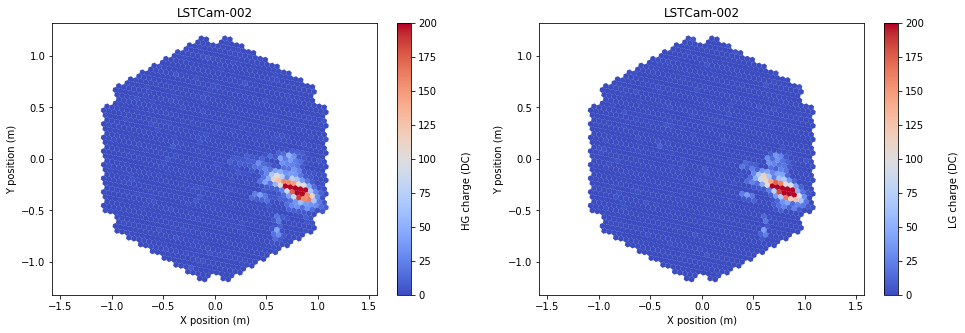

In [5]:
# loop on events

for i, event in enumerate(reader):
    
    # calibrate r0 --> r1        
    r0_r1_calibrator.calibrate(event)
   
    # if triggerd event
    if event.r0.tel[0].trigger_type != 32:                   
        
        # calibrate r1 --> dl1
        r1_dl1_calibrator(event)
        image = event.dl1.tel[tel_id].image
        
        # select image with bright event and stop
        if(np.max(image[0]>150)): 
            print(f"max pe {np.max(image[0])}")
            break
            
            
print(f"read event id: {event.r0.event_id}, trigger {event.r0.tel[0].trigger_type}")

# plot event

fig = plt.figure(figsize=(16, 5))

chan =0
ax = plt.subplot(1, 2, 1)
disp = CameraDisplay(event.inst.subarray.tels[0].camera)
disp.image = image[chan]  
disp.cmap = plt.cm.coolwarm
disp.set_limits_minmax(0,200)
disp.axes.text(2.4, 0, f'{channel[chan]} charge (DC)', rotation=90)
disp.add_colorbar()
print(f"channel {channel[chan]}: mean {image[chan].mean()} +- {image[chan].std()}")

ax = plt.subplot(1, 2, 2)
chan =1
disp = CameraDisplay(event.inst.subarray.tels[0].camera)
disp.image = image[chan]  
disp.set_limits_minmax(0,200)
disp.cmap = plt.cm.coolwarm
disp.axes.text(2.4, 0, f'{channel[chan]} charge (DC)', rotation=90)

disp.add_colorbar()
print(f"channel {channel[chan]}: mean {image[chan].mean()} +- {image[chan].std()}")


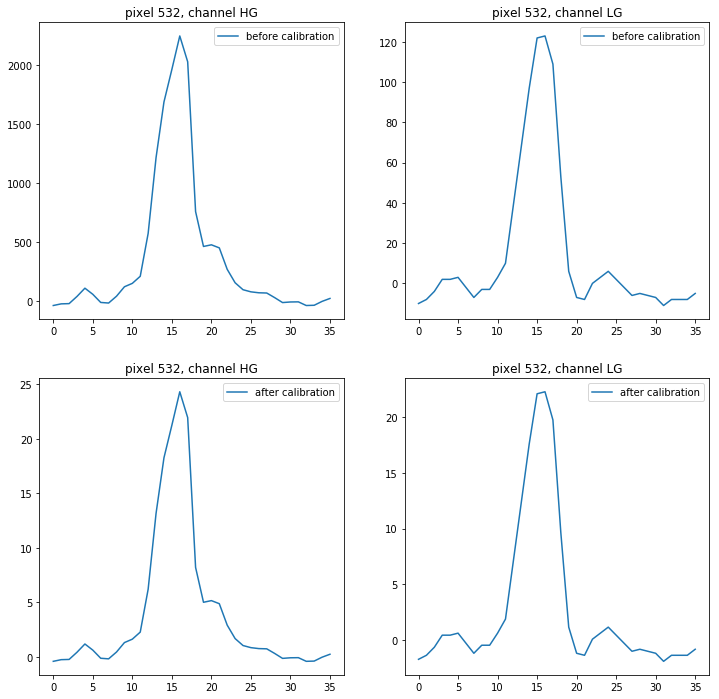

In [6]:
a=np.where(event.dl1.tel[0].image[0]>100)
pix=a[0][0]

fig = plt.figure(300,figsize=(12, 12))
label="after calibration"
label1="before calibration"
chan=0
plt.subplot(2, 2, 1)
plt.title(f"pixel {pix}, channel {channel[chan]}")
plt.plot(event.r1.tel[0].waveform[chan,pix], label=label1)
plt.legend()
plt.subplot(2, 2, 3)
plt.title(f"pixel {pix}, channel {channel[chan]}")
plt.plot(event.dl0.tel[0].waveform[chan,pix], label=label)   
plt.title(f"pixel {pix}, channel {channel[chan]}")
plt.legend()
chan=1
plt.subplot(2, 2, 2)
plt.title(f"pixel {pix}, channel {channel[chan]}")
plt.plot(event.r1.tel[0].waveform[chan,pix], label=label1)
plt.legend()
plt.subplot(2, 2, 4)
plt.plot(event.dl0.tel[0].waveform[chan,pix], label=label)
plt.title(f"pixel {pix}, channel {channel[chan]}")
plt.legend()
